In [23]:
from __future__ import division
import pystan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
f_sam = 65536 #Hz
dt = 1/f_sam
k_B = 1.38064881313131e-23  # Boltzmann constant (Newton metre/Kelvin)
T = 275 #Kelvin
beta = 1/(k_B*T)
N = 65536 #Number of data points

In [25]:
x = np.fromfile('position.txt',dtype=float,count=-1,sep = " ").reshape(N,1)
v = np.fromfile('velocity.txt',dtype = float, count=-1, sep = " ").reshape(N,1)

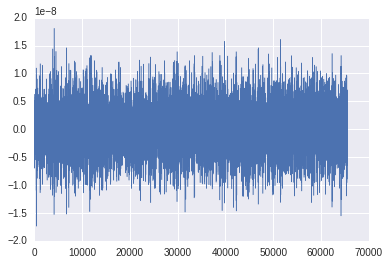

In [26]:
plt.plot(x,linewidth=0.5)

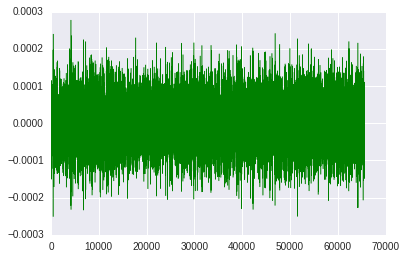

In [27]:
plt.plot(v,linewidth=0.5,color = 'g')

In [28]:
#matrix sufficient statistics
T1_11 = np.dot(np.transpose(x[1:N]),x[1:N])[0][0]
T1_12 = np.dot(np.transpose(x[1:N]),v[1:N])[0][0]
T1_21 = T1_12
T1_22 = np.dot(np.transpose(v[1:N]),v[1:N])[0][0]

T2_11 = np.dot(np.transpose(x[0:N-1]),x[1:N])[0][0]
T2_12 = np.dot(np.transpose(x[1:N]),v[0:N-1])[0][0]
T2_21 = np.dot(np.transpose(x[0:N-1]),v[1:N])[0][0]
T2_22 = np.dot(np.transpose(v[0:N-1]),v[1:N])[0][0]

T3_11 = np.dot(np.transpose(x[0:N-1]),x[0:N-1])[0][0]
T3_12 = np.dot(np.transpose(x[0:N-1]),v[0:N-1])[0][0]
T3_21 = T3_12
T3_22 = np.dot(np.transpose(v[0:N-1]),v[0:N-1])[0][0]


T1 = np.matrix([[T1_11,T1_12],[T1_21,T1_22]])
T2 = np.matrix([[T2_11,T2_12],[T2_21,T2_22]])
T3 = np.matrix([[T3_11,T3_12],[T3_21,T3_22]])

mu = T2*np.linalg.inv(T3)
alpha = T1 - mu*np.transpose(T2)
T11 = T3_11
T12 = T3_12
T21 = T3_21
T22 = T3_22

mu11 = mu[0,0]
mu12 = mu[0,1]
mu21 = mu[1,0]
mu22 = mu[1,1]
alpha11 = alpha[0,0]
alpha12 = alpha[0,1]
alpha21 = alpha[1,0]
alpha22 = alpha[1,1]

In [29]:
mvoup_code = """
data {
    int<lower=0> N;    // number of data points
    real<lower=0> dt;  // sampling interval 
    real beta;         // 1/k_B*T
    real mu11;         // mu is the sufficient statistic T_2*(T_3)^-1
    real mu12;
    real mu21;
    real mu22;
    real alpha11;      //alpha is the sufficient statitic T_1 - T_2*(T_3)^-1*T_2'
    real alpha12;
    real alpha21;
    real alpha22;
    real T11;         // T is the sufficient statistic T_3
    real T12;
    real T21;
    real T22;

}
transformed data {
}
parameters {
    real<lower=0> m;       // mass
    real<lower=0> k;      // spring constant
    real<lower=0> gamma;  // friction coeffiecient

}
transformed parameters {
}
model {
    real D;
    real omega;
    real tau;
    real omega_0;
            
    real l11;    // l is the matrix exponential exp(-lambda*dt)
    real l12;
    real l21;
    real l22;
    
    real s11;   // s is the inverse of the Sigma matrix
    real s12;
    real s21;
    real s22;
    
    real sig11;  // sig is the Sigma matrix
    real sig12;
    real sig21;
    real sig22;
    
    real M11;    // M is the contracted product Sigma^(-1) : exp(-lambda*dt)
    real M12;
    real M21;
    real M22;
    
    D <- 1/(beta*gamma);
    tau <- m/gamma;
    omega_0 <- sqrt(k/m);
    omega <- sqrt((omega_0*omega_0)-(1/(4*tau*tau)));

    
    l11 <- exp(-dt/(2*tau))*(cos(omega*dt)+(1/(2*omega*tau))*sin(omega*dt));
    l12 <- exp(-dt/(2*tau))*((1/omega)*sin(omega*dt));
    l21 <- exp(-dt/(2*tau))*((-omega_0*omega_0/omega)*sin(omega*dt));
    l22 <- exp(-dt/(2*tau))*(cos(omega*dt)-(1/(2*omega*tau))*sin(omega*dt));
    
    sig11 <- (D/(4*omega*omega*omega_0*omega_0*tau*tau*tau))*((4*omega*omega*tau*tau)+exp(-dt/tau)*(cos(2*omega*dt)-(2*omega*tau*sin(2*omega*dt))-(4*omega_0*omega_0*tau*tau)));
    sig22 <- (D/(4*omega*omega*tau*tau*tau))*((4*omega*omega*tau*tau)+exp(-dt/tau)*(cos(2*omega*dt)+(2*omega*tau*sin(2*omega*dt))-(4*omega_0*omega_0*tau*tau)));
    sig12 <- (D/(omega*omega*tau*tau))*exp(-dt/tau)*sin(omega*dt)*sin(omega*dt);
    sig21 <- (D/(omega*omega*tau*tau))*exp(-dt/tau)*sin(omega*dt)*sin(omega*dt);
    
    s11 <- (1/(sig11*sig22-sig12*sig21))*sig22;
    s12 <- -(1/(sig11*sig22-sig12*sig21))*sig12;
    s21 <- -(1/(sig11*sig22-sig12*sig21))*sig21;
    s22 <- (1/(sig11*sig22-sig12*sig21))*sig11;
    
    
    
    
    M11 <- T11*(l11-mu11)*(l11-mu11)+T21*(l12-mu12)*(l11-mu11)+T12*(l11-mu11)*(l12-mu12)+T22*(l12-mu12)*(l12-mu12)+alpha11;
    M12 <- T11*(l11-mu11)*(l21-mu21)+T21*(l12-mu12)*(l21-mu21)+T12*(l11-mu11)*(l22-mu22)+T22*(l22-mu22)*(l12-mu12)+alpha12;
    M21 <- T11*(l11-mu11)*(l21-mu21)+T21*(l11-mu11)*(l22-mu22)+T12*(l12-mu12)*(l21-mu21)+T22*(l22-mu22)*(l12-mu12)+alpha21;
    M22 <- T11*(l21-mu21)*(l21-mu21)+T21*(l21-mu21)*(l22-mu22)+T12*(l21-mu21)*(l22-mu22)+T22*(l22-mu22)*(l22-mu22)+alpha22;
    increment_log_prob((N/2)*log((s11*s22-s12*s21)/(4*pi()*pi()))-0.5*(s11*M11+s12*M12+s21*M21+s22*M22));
}
generated quantities {
}
"""

# model compilation
model = pystan.StanModel(model_code=mvoup_code)

In [30]:
#providing experimental data
MVOU_data = { 'N':N, 'dt':dt, 'beta':beta, 'mu11':mu11, 'mu12':mu12, 'mu21':mu21, 'mu22':mu22, 'alpha11':alpha11, 'alpha12':alpha12, 'alpha21':alpha21, 'alpha22':alpha22, 'T11':T11, 'T12':T12, 'T21':T21, 'T22':T22}

In [31]:
#model fitting using MCMC
fit_stan = model.sampling(data=MVOU_data, chains=4, iter=1000)

In [32]:
fit_stan

Inference for Stan model: anon_model_afe63b2c2fe3ff1a0e4f42b4161e5da8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m       0.38    0.19   0.27   0.09   0.16   0.31   0.63   0.82    2.0    nan
k       2.97    1.28   1.81   1.17   1.25   2.59   4.76   5.52    2.0    nan
gamma   0.94     0.3   0.42   0.36   0.53   1.03   1.34   1.35    2.0    nan
lp__ -1.3e20  1.4e20 1.9e20-4.6e20-2.6e20-2.1e19-9.3e18-1.6e18    2.0 2.6e14

Samples were drawn using NUTS(diag_e) at Mon Mar 27 19:28:12 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

(<matplotlib.figure.Figure at 0x7f2057eb94d0>,
 <matplotlib.figure.Figure at 0x7f206b732c90>)

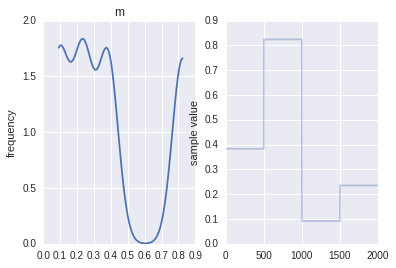

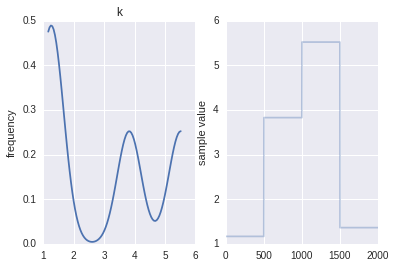

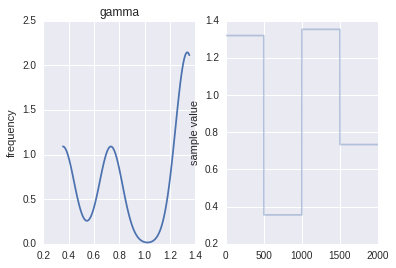

In [33]:
fit_stan.plot('m'), fit_stan.plot('k'), fit_stan.plot('gamma')